# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

The smartcab is stationary.  Messages on the screen indicate that its state is not updated.  It sits still so it gets points when there's a red light (because it is stopped) and gets penalized during green lights when it should be moving.  These rewards/penalties correspond to the smartcab behavior relative to traffic rules. Deadline for completing its goals seems to not be active.  However, after some time the current trial does end in failure (presumably because destination is not reached), and the smartcab is moved to a different location on the map for the new trial.  A bunch of other cars of various colors are simulated and moving around on the map.  There's a Udacity symbol at one of the intersections.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

I will pick three boolean flags that were documented and show their comments which describes their effects on the simulation and a couple of thoughts on their impact.

Flag 1: *verbose* - set to True to display additional output from the simulation.  The verbose flag is a member of the simulation object.  If set to True a number of print statements outputing for simulation information will execute.

Flag 2: *learning* - set to True to force the driving agent to use Q-learning.  The actual learning logic seems not to have been implemented at this stage of the project.  Current it mainly controls logging of learning parameters.

Flag 3: *enforce_deadline* - set to True to enforce a deadline metric.  Used for controlling output and logging relative to whether deadline is met by the smartcab.  Also when True results in a penalty based on time remaining.

The Environment class function *act* is called when an agent performs an action.  This function returns a reward/penalty for the chosen action.

The render_text() method just output textual information using the print() method.  The render() method update the pygame raster display with graphical changes using methods like pygame.draw() and screen.blit().

The next_waypoint() method considers the East-West direction first.

In terms of understanding the code, I think it's also important to understand how the environment is simulated.  A key part of this are the lines 300-358 in environment.py that determines how traffic violations and collisions are determined as well as their scoring.  It is interesting that lane considerations are taken into account and assumptions are made about all other cars obeying traffic lights when determining the potential for collisions.  For example, on a green light it's ok to turn left if there's no oncoming traffic or oncoming traffic is turning left, but not if oncoming traffic is turning right which will but both cars into the same lane.  Cars on the left and right are not considered at all for collision because they're assumed to obey the red light currently active for cross-traffic (or turning right which won't conflict).

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!


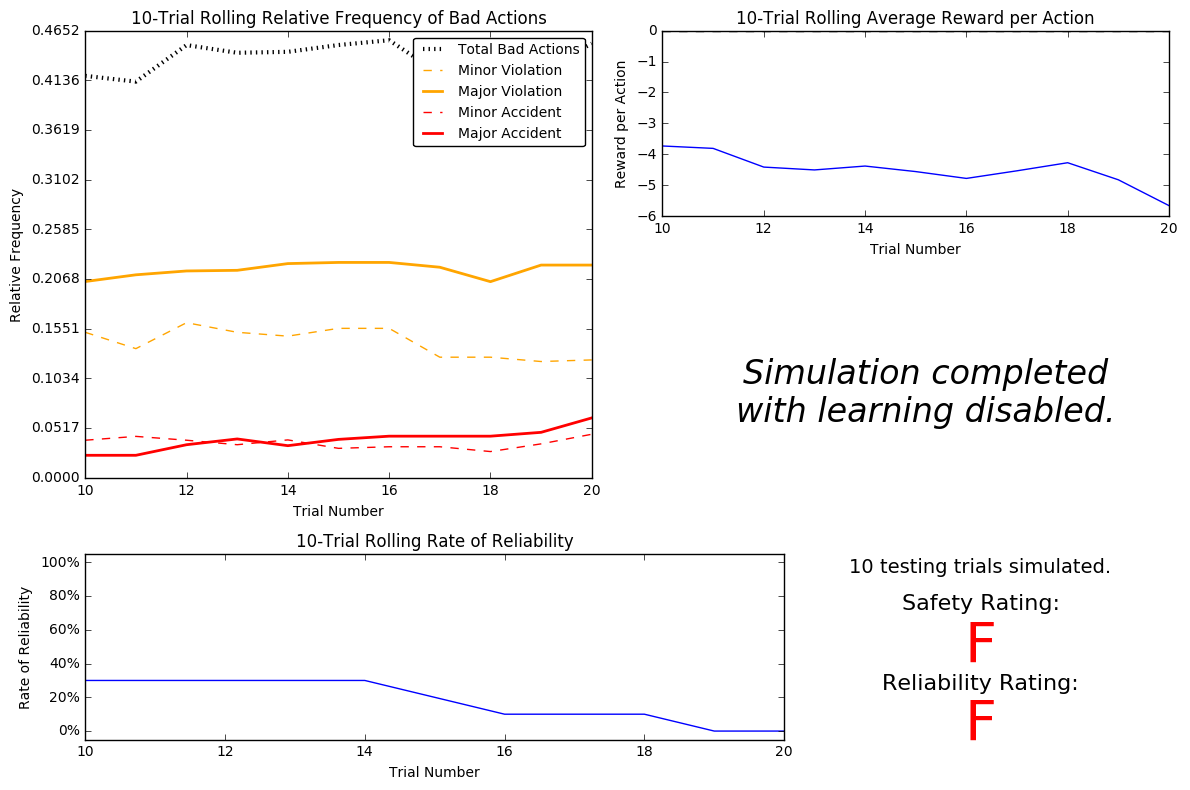

In [10]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

Bad actions were made between 30% - 40% of the time, with major violations being the most frequent bad action at around 20% of the time.  Major and minor accident frequencies were around 0.5% of the time, for an accident total of around 1% of the time.  Rate of reliablity showed the last 11 rates of reliability with a mean of 22.7%.  That's close enough to 25% which is what I'd expect for reliability of a random choice between 4 actions.  Penalties varied between -3.5 to -5, which is around the penalty for the least penalized offense, the minor traffic violation.  This is probably dominated by, and is around the value of, the expectation of penalties for major traffic violations since that is the most frequent offense by far.

There seems to be a slight trend of increasing violation frequency in all categories in the later trials from the above graphs, with the corresponding increase in penalites, but I am not sure if this is a real dynamic or an artifact of the random number generator for this set of trials.  Running multiple iterations of this test can shed more light on this.  In any case, as expected random behavior is definitely not safe nor reliable given the various minor and major accidents as well as the 80% failure rate.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**

The inputs: light, left, right, and oncoming all impact safety and efficiency.  They impact safety because their information are relevant for preventing traffic violations and accidents.  They impact efficiency because their information can be useful in determine an efficient path to the goal.  I would include all the input features in the model of the smartcab environment.  Waypoint impacts efficiency by helping the smartcab to take the most direct route to the goal.  I would argue that this also effect safety because the more efficient the path, the less there is the chance for accidents.  It's not safe to just wander around the map without any guidance, so I would also include this feature.  Deadline impact efficiency because it provides a constraint on the overall travel time, but we're not going to run a red light or make a turn into oncoming traffic just because we're nearing the deadline.  I would not include the deadline in the environment model.  The Smartcab is just going to take however long it needs to take to get to the goal safely using an efficient path.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

Here are they number of individual states of each feature:  waypoint: 3 (forward, right, left), light: 2 (red, green), left: 4, right: 4, oncoming: 4 (None, forward, left, and right for the previous 3).  Multiply all of these numbers together to get the total number of state combinations and the result is 384 possible state combos.  384 is not that large a number given that in computer simulations tens of thousands of runs (w/o display) can be done in probably some short amount of time, so learning reasonable behavior for 384 state combos should be no problem.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

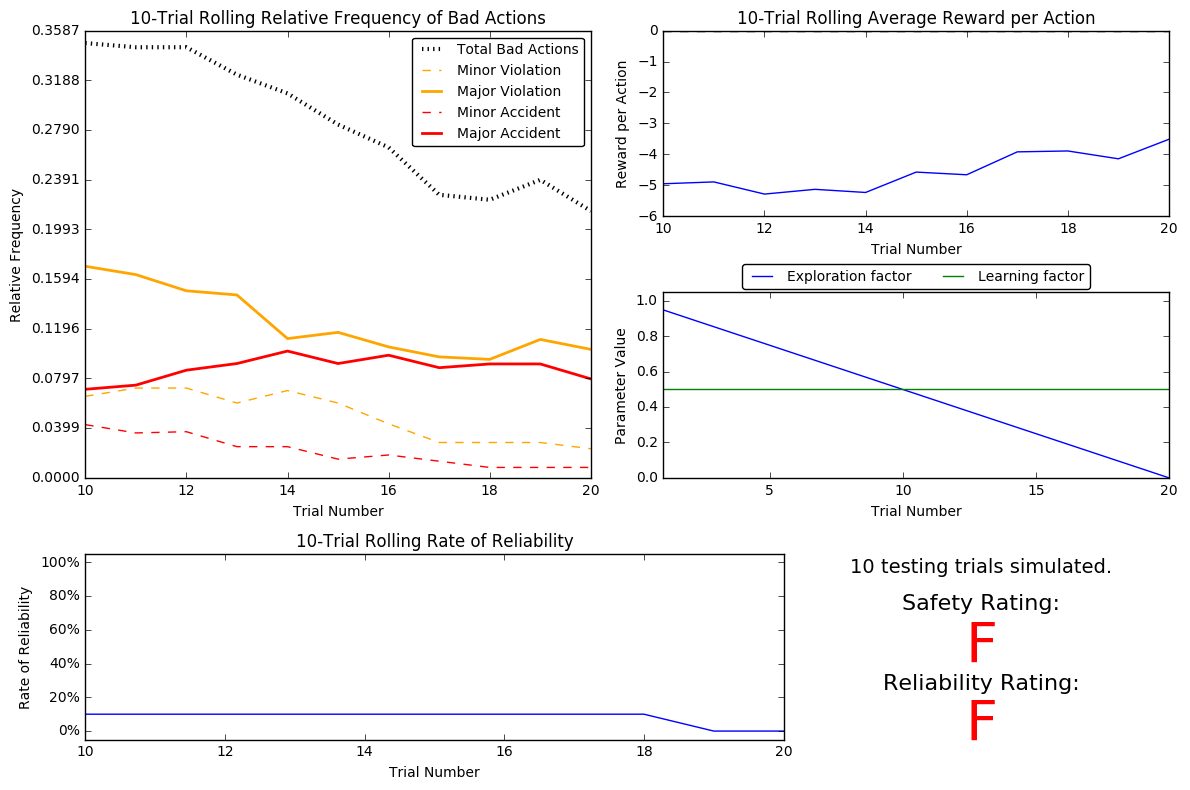

In [4]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

There were 20 training trials which is the 20-step linear decay of epsilon from 1.0 in steps of 0.05 to the testing threshold 0.05.  Both the grades for reliability and safety remained F's like with the basic driving agent, but wow... there seems to be signs of learning!  Bad action percentage starts at 35% of the time but decreased slightly to around 20% over the 20 training trials. Both major and minor violations and minor accidents also slightly decreased, but major accidents increased slightly, another similarity with the basic driving agent.  Average rewards also slightly increased from -5 to -3.5 over the 20 training trials. However the rate of reliability at 10% or lower is actually below the basic driving agent.  The decaying function for epsilon and the constant-ness of alpha at 0.5 were both represented accurately in the parameters panel.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

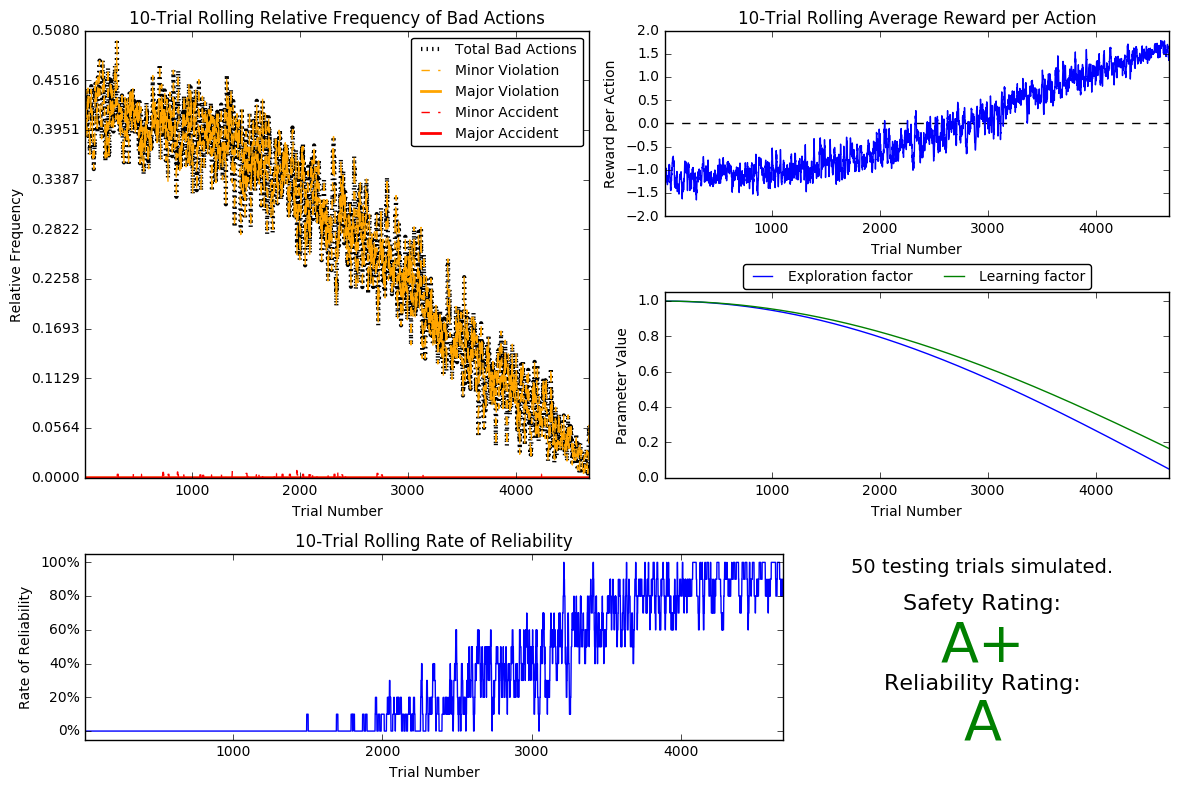

In [4]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

*Note:* I made 8 different improvement attempt and captured the visualizations of these attempts in images named attempt_1.png through attempt_8.png.  I will refer to these images throughout my answer for this question.

To test the improved learning, I increased n_test to 50 for more granular and robust testing of the learning result.  With more testing trials, more of the rough edges of the learned behavior will have more chance to reveal themselves.

My first attempt was to keep the linear decay for epsilon but increasing the training iteration, first to 100 training trials and then to 300 training trials (see attempt_1.png & attempt_2.png).  However, for both attempts, the grades for both safety and reliablity remained F.

Looks like we need to look at the epsilon decay functions.  The epsilon = a^t decay function is practically linear for useful values a.  The epsilon = 1 / t^2 decays way too quickly.  The only two choices that provided good alternatives to linear decay are epsilon = e ^ (-at), which switches more quickly than linear from exploration to exploitation (epsilon > 0.5 for t < 0.25 of total training trials), and epsilon = cos(at), which spends more time exploring randomly (epsilon > 0.5 for t < 0.7 of total training trials) than linear decay.  

Intuitively I wanted to start exploiting earlier so I chose epsilon = e ^ (-at) calibrated to around 300 trials for comparison to attempt 2.  The result of this third run is in attempt_3.png.  This third attempt improved safety to C, so no accidents, and reliability to D.  One reason for these notable improvements from linear epsilon decay is that positive reward was achieved quicker (at around 100 trials instead of 150 for linear) due to earlier exploitation.

Next I tried decreasing the learning rate alpha linearly.  Both safety and reliability regressed to F (attempt_4.png).  Then I tried increasing the learning rate alpha linearly (attempt_5.png) and reliability improved to C and safety improved to D from the previous attempt but was worse than attempt 3 with constant alpha.

Performance isn't great with the exponential epsilon decay, so I tried the cosine decay which favors more exploration in the beginning (attempt_6.png).  This unfortunately did not work well, with reliability rating of D and safety rating of F.

It seems like more training might help at this point, so I tried quadrupling the learning trials to around 1200 with the same exponential epsilon decay and constant 0.5 alpha (attempt_7.png). This resulted in the grade C for both safety and reliability.  

Trying 1200 training trials with cosine decay and constant 0.5 alpha instead (attempt_8.png) resulted in the first breakthrough with safety of A+ and reliability of B.  In the real world an A+ safety rating is what I would aim for, despite the fact that many if not most human drivers will violate any number of traffic rules for expediency.  I believe that robotic drivers should have a higher standard.  The passing requirement for this project requires a minimum of grade of A for both safety and reliability, indicating some tolerance of minor traffic rule violations for reliability.

Taking the following review hints:

    Increasing the learning rate may lead to faster convergence
    
    On the other hand, decreasing the learning rate may avoid high fluctuations in the policy

I thought to try having the learning rate high at the start of training for earlier convergence and having the learning rate low later in the training to reduce policy fluctuations.  The cosine function already exhibit these behaviors.  I added an alpha_param parameter to be used to calculate the alpha as a function of the training step, and chose a value that have the learning rate decay slower than the epsilon exploration factor.  The result is captured in attempt_9.png.  There was certainly faster convergence but the grades of A+ safety and B reliability was the same as attempt 8.

At this point the learning looks pretty good in the visualization so I just tried adding 1000 training steps to around 2200 (attempt_10.png).  This resulted in a safety grade of A+ and a reliability score of A.

Going from F reliability and F safety in the default Q-learner to A reliability and A+ safety in the improved Q-learner is quite a jump.  The decay in rolling relative frequency of bad action is striking, with the agent rapidly learn to trade minor traffic violations for the more severe violations and accidents from the beginning and then driving the frequency of these down from 40+% to near zero is quite impressive.  Early emphasis on exploration and sufficient number of training steps seems to be necessary to fully explore the state space and train the agent to behave reliably and safety.  Not enough training steps and/or exploration will result in insufficient learnings and flawed policies that cause unsafe behavior or lower reliability in some of the states.

After submission of the above, I got two code issues on review.  One was an inconsequential missing boolean to not run the learning code when agent.learning=False.  The second, however, points to a bias in my action selection.  It turns out that my code always selects the first action (in the valid action enumeration) if there are multiple actions with the same q value.  Well, there were still a number of states that have multiple q values of 0 and no q value > 0.  By always selecting the first among these actions, which is None, I was by default picking a choice that would produce no accidents.  When I changed this code to randomly select from all values that has the current maximum Q value, the performance substantially degraded to D safety and B reliability (attempt_11.png).  This means that for any state where a positive reward has not been learned, the agent will select randomly from among all the actions that still have 0 reward, meaning somewhat random behavior for these states.  I need to increase the learning trials number until the agent has a positive reward for all 384 states.

I think though that to solve this only more learning is needed and increased the training trial count to around 4700 (attempt_12.png).  With that the safety grade returned to A+ and the reliability grade returned to A.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** 

Some examples of optimal policy, which for me requires no traffic violation:

*Stopping at red light:*  waypoint:[any but right], light:[red], oncoming:[any], left:[any], right[any] --- action: none

*Turrning right at red light if safe:*  waypoint:[right], light:[red], oncoming:[right or forward], left:[right], right[any] --- action: right

*Going forward safely toward aimpoint:*  waypoint:[forward], light:[green], oncoming:[forward], left:[right], right:[none] -- action: forward

*Going on green safely even when cannot move toward aimpoint:*  waypoint:[left], light:[green], oncoming:[forward or right], left:[any], right:[any] -- action: forward

*Turning left safety toward aimpoint:*  waypoint:[left], light:[green], oncoming:[none], left:[right], right:[right] -- action: left

*Stop at green light to prevent accident:* waypoint:[forward], light:[green], oncoming:[left], left:[forward], right:[forward] -- action: none

There are 384 states recorded.  I won't be able to examine all of them, but below are several interesting examples and some comments following each.  Note that states below are in the following order: waypoint, light, oncoming, left, right.  

('right', 'green', 'forward', 'left', 'right')
 -- forward : 0.88
 -- right : 0.00
 -- None : -5.49
 -- left : 0.00

*Optimal Policy:* No, seems like highest reward should be 'right' instead of 'forward' on 'green' here with waypoint to the 'right'.

('right', 'green', None, 'forward', 'forward')
 -- forward : -0.39
 -- right : 1.50
 -- None : -4.47
 -- left : 0.00

*Optimal Policy:* Yes, highest reward is for 'right' on 'green' with waypoint to the 'right'.

('right', 'red', 'left', None, 'forward')
 -- forward : 0.00
 -- right : 0.00
 -- None : 1.96
 -- left : 0.00
 
*Optimal Policy:* Yes, oncoming traffic turning 'left' means 'right' at this 'red' light will result in accident.

('left', 'red', 'forward', 'forward', 'left')
 -- forward : 0.00
 -- right : 0.00
 -- None : 1.72
 -- left : 0.00

*Optimal Policy:* Yes, Stop on 'red' here with waypoint to the 'left'.

('right', 'red', 'forward', 'left', None)
 -- forward : 0.00
 -- right : 0.00
 -- None : 1.87
 -- left : 0.00

*Optimal Policy:* No, seems like 'right' would be optimal on 'red' light here with no conflict for turning right.



-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

One characteristic that invalidate the use of future rewards is the lack of indication of position and direction of other vehicles for more than one time step which makes planning more than one step ahead toward a future reward counter-productive.  This can be considered a limitation of the sensors of the smartcab.  

The environment is also updated one time step at a time, with no environment information or knowledge for more than one step ahead.  This also precludes the usefulness of any future planning.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.